In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Robert_Bosch/dataset/Test_data/
# %ls 
# # %mkdir -p dataset
# !pip install ipdb
# # !unzip Test_data.zip -d dataset

In [3]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 6AF2-6DB7

 Directory of C:\Users\sathy\Downloads\Test_data

25-07-2021  20:57    <DIR>          .
25-07-2021  20:57    <DIR>          ..
25-07-2021  16:37    <DIR>          .ipynb_checkpoints
25-07-2021  21:05    <DIR>          data
25-07-2021  02:05    <DIR>          Documents
25-07-2021  01:02    <DIR>          files
25-07-2021  17:16           260,414 Project_Report.pdf
25-07-2021  16:37           318,032 Robet_Bosch_Viper- Final-Submission.ipynb
25-07-2021  17:15           331,535 Robet_Bosch_Viper.ipynb
25-07-2021  17:15           589,165 Robet_Bosch_Viper.pdf
14-04-2021  11:31            23,686 Sample_Submission.csv
14-04-2021  11:27    <DIR>          Test
22-07-2021  14:53         2,289,698 Test_data.7z
14-04-2021  11:27    <DIR>          Train
14-04-2021  11:27    <DIR>          Val
25-07-2021  02:05    <DIR>          weights
               6 File(s)      3,812,530 bytes
              10 Dir(s)  223,679,569,920 bytes fr

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipdb 
import pandas as pd
import os
os.chdir('./')
train_test_val = 0
dataset = []
k_fold = True
# folders_to_look = ['Train/','Val/','Test/'] if k_fold==True else ['Train/']
classes = [cl.split('/')[1] for cl in glob.glob('Train/'+'/*')] #Class names
cls_len = len(glob.glob('Train/'+'/*')) #Number of Classes in the dataset

for folder in glob.iglob('*/'):
#     if(train_test_val == 0):
#         if(folder in folders_to_look):
    if(folder == 'Test/'):
        
        for files in glob.iglob(folder+"/*.jpg"):
            img_path = files
            dataset.append((img_path,-1))
        
    else:
        
        for classess in glob.glob(folder+'/*'):
            for files in glob.iglob(classess+"/*.jpg"):
                img_path = files
                class_id = classes.index(files.split('/')[1])
                dataset.append((img_path,class_id))


df = pd.DataFrame(dataset,columns=['image_path','class'])
# dataset = np.asarray(dataset)
train_df, val_df, test_df = df.iloc[:970],df.iloc[970:], df.iloc[970+2910:]
print("Data Points:")
print("Train:",len(train_df),"Validate:",len(val_df),"Test:",len(test_df))


#Checking for Class Imbalance
cls, counts = np.unique(train_df['class'].values, return_counts=True)
# print([print("class:",classes[cls[i]],"counts:",counts[i]) for i in range(cls_len)])
# Hence no class imbalance



IndexError: list index out of range

In [5]:
class config:
    test = True
    triplet = False
    num_classes = len(classes)
    clases = classes
    train_batch_size = 8*4 # Reduce if triplet is True, defualt : 8*4*4
    val_batch_size = 8*4*4

In [6]:
#k-Fold Validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=6)
skf.get_n_splits(len(df))
fold = 0
df['fold'] =0 
for train_index, test_index in skf.split(df['image_path'],df['class']):
    df['fold'].loc[test_index]=fold
    fold+=1
    

/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
classes

['human', 'animal', 'truck', 'car', 'airplane']

In [8]:

import torch
from skimage import io, transform
import numpy as np

import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pytorch_lightning.callbacks import ModelCheckpoint
from torchcontrib.optim import SWA
from pytorch_lightning.metrics import Metric
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import albumentations as A
from albumentations.pytorch import ToTensorV2
import imgaug.augmenters as iaa


class vdataset(Dataset):
    def __init__(self, df, triplet=False, test=False ,transform=None):
        self.df = df
        self.transforms = transform
        self.triplet = triplet
        self.test = test
    def __len__(self):
        return len(self.df)
    def read_image(self, image_path):
        image = cv2.imread(image_path).astype(np.float32)
        image = (image-np.min(image))/(np.max(image)-np.min(image))
        
        if self.transforms:
            image = self.transforms(image=image)
            image = image['image']
        else:
            image = np.moveaxis(image,-1,0)
        return image
        
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        anchor_image_path, anchor_label = data['image_path'], data['class']
        anchor_image = self.read_image(anchor_image_path)
        
        if self.triplet:                  #For Siamese Triplet Learning
            if(anchor_label ==1 or anchor_label ==2 or anchor_label ==3):
                if(anchor_label ==1):
                    p=[0.4,0,0.2,0.2,0.2]
                elif(anchor_label ==2):
                    p=[0.2,0.2,0,0.4,0.2]
                elif(anchor_label ==3):
                    p=[0.2,0.2,0.4,0,0.2]

                anchor_label_neg =np.random.choice(range(5),size=1,p=p)
                negative_index = np.random.choice(train_df[train_df['class']==anchor_label_neg[0]].index)
                negative_image_path, negative_label = train_df.iloc[negative_index]
                negative_image = self.read_image(negative_image_path)
                
                
            else:
                
                negative_index = np.random.choice(train_df[train_df['class']!=anchor_label].index)
                negative_image_path, negative_label = train_df.iloc[negative_index]
                negative_image = self.read_image(negative_image_path)


            positive_index = np.random.choice(train_df[train_df['class']==anchor_label].index)
            positive_image_path, positive_label = train_df.iloc[positive_index]
            positive_image = self.read_image(positive_image_path)

            return (anchor_image,anchor_label), (positive_image, positive_label),(negative_image, negative_label)
        
        else:
            if self.test:
                return anchor_image_path, anchor_image,torch.tensor(anchor_label)
            else:
                return anchor_image,torch.tensor(anchor_label)



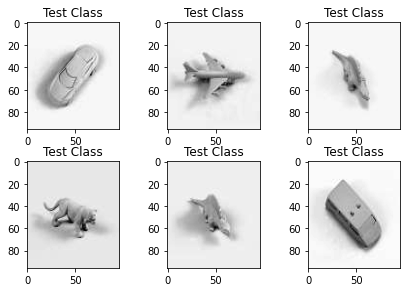

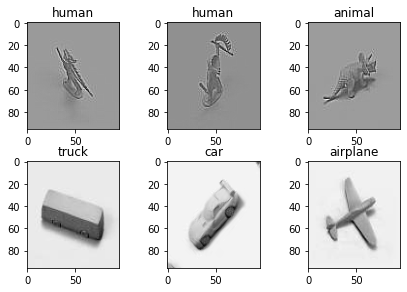

In [16]:
train_transform = A.Compose(
    [
#        A.ShiftScaleRotate(rotate_limit=(-360, 360), shift_limit=(0.1, 0.12), scale_limit=(0.1, 0.12)),
       A.HorizontalFlip(p=0.5),
       A.Sharpen(alpha=(0.3,0.5), lightness=(0.5, 1.0), always_apply= False, p=0.6) ,
       A.Rotate (limit=180),
#       A.RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.2,p=0.5),
#         iaa.Sequential([
#         iaa.Canny(alpha=(0.0, 0.6))
#              ]).augment_image,
#       A.Affine (scale=None, translate_percent=None, translate_px=None, rotate=None, shear=(0,15),
#                 interpolation=1, cval=0, cval_mask=0, mode=0, fit_output=False, always_apply=False, p=0.5),
#        A.RandomBrightnessContrast(contrast_limit=0.2, always_apply=False, p=0.5),
#        A.Perspective(scale=(0.05, 0.1)),
#        A.Affine (scale=1,translate_percent=0.1,fit_output=True),
       ToTensorV2(),
    ]
)




valid_transform = A.Compose(
    [
       ToTensorV2(),
    ]
)

val_dataset = vdataset(val_df, transform = valid_transform)

val_dataloader = DataLoader(val_dataset, batch_size=8*4,
                        shuffle=False, num_workers=32)

test_dataset = vdataset(test_df, test= config.test, transform = valid_transform)

test_dataloader = DataLoader(test_dataset, batch_size=8*4,
                        shuffle=False, num_workers=32)

if config.test:
    
    fig, axs = plt.subplots(2,3)
    fig.tight_layout()
    cls_ind = 0
    for i in range(2):
        for j in range(3):
            path ,test_sample,cls = test_dataset.__getitem__(190*cls_ind)
            axs[i][j].imshow(test_sample[0,:],cmap='gray', aspect='auto')
            axs[i][j].set_title("Test Class")
            cls_ind+=1
    plt.show()



if (config.triplet==True):
    #Triplet Visualization

    train_dataset_triplet = vdataset(train_df,triplet=True, transform = train_transform)


    train_dataloader_triplet = DataLoader(train_dataset_triplet, batch_size=8,
                            shuffle=True, num_workers=32)


    fig, axs = plt.subplots(5, 3)
    fig.tight_layout()
    cls_ind = 0
    for i in range(5):

        (anc,cls),(pos,cls),(neg,neg_cls) = train_dataset_triplet.__getitem__(197*i+1)
        axs[i][0].imshow(anc[0,:],cmap='gray',aspect='auto')
        axs[i][0].set_title(classes[cls])
        axs[i][1].imshow(pos[0,:],cmap='gray', aspect='auto')
        axs[i][1].set_title(classes[cls])
        axs[i][2].imshow(neg[0,:],cmap='gray', aspect='auto')
        axs[i][2].set_title(classes[neg_cls])

    plt.show()

else:
    train_dataset = vdataset(train_df, transform = train_transform)



    train_dataloader = DataLoader(train_dataset, batch_size=8*4,
                        shuffle=True, num_workers=32)
    fig, axs = plt.subplots(2,3)
    fig.tight_layout()
    cls_ind = 0
    for i in range(2):
        for j in range(3):
            test_sample,cls = train_dataset.__getitem__(190*cls_ind)
            axs[i][j].imshow(test_sample[0,:],cmap='gray', aspect='auto')
            axs[i][j].set_title(classes[cls])
            cls_ind+=1
    plt.show()




In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def conv_res(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class res_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(res_block, self).__init__()
        self.conv1 = conv_res(in_channels, out_channels, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv_res(out_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn(self.conv1(x)))
        out = self.bn1(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class res_net(nn.Module):
    def __init__(self, block, layers, triplet=False, num_classes=10):
        super(res_net, self).__init__()
        self.in_channels = 16
        self.triplet = triplet
        self.conv = conv_res(3, 8)
        self.conv1 = conv_res(8, 16)
        self.bn = nn.BatchNorm2d(8)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.rep_layer(block, 16, layers[0])
        self.layer2 = self.rep_layer(block, 32, layers[1], 2)
        self.layer3 = self.rep_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc1 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(64, num_classes)
        self.sigmoid = nn.Sigmoid()

        
    def rep_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv_res(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward_pass(self,x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.relu(self.bn1(self.conv1(out)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out
    
#     def dual_pass(self, x1, x2):
#         return self.sigmoid(self.forward_pass(x1)), self.sigmoid(self.forward_pass(x2))
        
    def forward(self, x):
       
        if self.triplet:

            return self.forward_pass(x)
        
        else:
            out = self.relu(self.forward_pass(x))
            return self.fc2(out)
        
    
# resnet = res_net(res_block, [4, 16, 16*2], triplet=True, num_classes=len(classes))
# 
resnet = res_net(res_block, [8, 36, 48], triplet=True, num_classes=len(classes))
from torchsummary import summary
summary(resnet,(3,96,96))



Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

In [11]:
checkpoint_callback_cn = ModelCheckpoint(
        monitor='train_loss',
        mode = 'min',
        save_last=True,
        dirpath='weights/triplet_loss',
        filename='CE_loss-{epoch:02d}-{train_loss:.8f}'
    )

checkpoint_callback = ModelCheckpoint(
        monitor='valid_acc',
        mode = 'max',
        save_last=True,
        dirpath='weights/triplet_loss+focal/256_CE_8,36,48-P',
        filename='CE_loss-{epoch:02d}-{valid_acc:.3f}'
    )
import wandb

import ipdb
class ContrastiveLoss(nn.Module):
    
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.margin = 1.
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (float(target) * distances +
                        float(1 + -1 * target) * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()
    
contrastive_loss = ContrastiveLoss()

class Net(pl.LightningModule):
    def __init__(self, model, triplet=False):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy()
        self.triplet = triplet
        self.triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)
        self.alpha = 1
        self.gamma = 2
        self.relu = nn.ReLU()

    def forward(self, x1, x2=None):
        if self.triplet:
            embedding1 = self.model(x1)
            embedding2 = self.model(x2)
            return embedding1, embedding2
        
        else:

            embedding = self.model(x1)
            return embedding

    def configure_optimizers(self):
        self.optimizer = SWA(torch.optim.Adam(self.model.parameters(),  lr=1e-8))
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                    T_max=10,
                                                                    eta_min=1e-2,
                                                                    verbose=True)

        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

    def training_step(self, train_batch, batch_idx):
        if self.triplet:
            (anc,lab_anc),(pos,lab_pos),(neg,lab_neg) = train_batch
           
            z_anc = self.model(anc)
            z_pos = self.model(pos)
            z_neg = self.model(neg)
            cont_pos = contrastive_loss(z_anc, z_pos, 1)
            cont_neg = contrastive_loss(z_anc, z_neg, 0)
            
            
            z = self.fc2(self.relu(z_anc))
            z = self.fc3(self.relu(z))

           #Contrastive Loss

    
            
            
            CE_loss = F.cross_entropy(z,lab_anc)
            pt = torch.exp(-CE_loss)
            F_loss = self.alpha * (1-pt)**self.gamma * CE_loss
            
            loss = self.triplet_loss(z_anc, z_pos, z_neg) + F_loss# + cont_pos + cont_neg
            acc = self.accuracy(z, lab_anc)
            logs = {'train_loss': loss,'train_acc':acc , 'lr': self.optimizer.param_groups[0]['lr']}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            return loss

        
        else:
            x, y = train_batch
            z = self.relu(self.model(x))
            z = self.relu(self.fc2(z))
            z = self.fc3(z)
            loss = F.cross_entropy(z,y)
            acc = self.accuracy(z, y)
            logs = {'train_loss': loss, 'train_acc': acc, 'lr': self.optimizer.param_groups[0]['lr']}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            return loss

    def validation_step(self, val_batch, batch_idx):

            x, y = val_batch
            z = self.relu(self.model(x))
            z = self.fc2(z)
            z = self.fc3(self.relu(z))
            loss = F.cross_entropy(z, y)
            acc = self.accuracy(z, y)
            logs = {'valid_loss': loss, 'valid_acc': acc}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            wandb.log({"valid_acc": acc})
            return loss
  
    def training_epoch_end(self, outs):
        self.log('train_acc_epoch', self.accuracy.compute())

# model


# training


if config.test==False:
    wandb.init()

    wandb.watch(resnet)
    model = Net(resnet, triplet=config.triplet)
    trainer = pl.Trainer(gpus=1,precision=16, max_epochs=600, callbacks=[checkpoint_callback])
    trainer.fit(model, train_dataloader_triplet, val_dataloader)
    
    
    


In [12]:
# #Train Final Classification Layers



class final_net(nn.Module):
    def __init__(self, model):
        super(final_net, self).__init__()
        self.model = model
#         self.accuracy = torchmetrics.Accuracy()
#         self.triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
#         self.fc2 = nn.Linear(576, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        out = self.model(x)
#         out = self.fc2(out)              #Without ReLU
#         out = self.fc2(nn.ReLU(out))
        out = self.fc2(self.relu(out))
        out = self.fc3(self.relu(out))
        return out


    
FN = final_net(resnet)
chkpoint = torch.load('./weights/triplet_loss+focal/256_CE_8,36,48/CE_loss-epoch=193-valid_acc=0.781.ckpt')['state_dict']

FN.load_state_dict(chkpoint)

# from torchsummary import summary
summary(FN,(3,96,96))


Layer (type:depth-idx)                   Output Shape              Param #
├─res_net: 1-1                           [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 8, 96, 96]           216
|    └─BatchNorm2d: 2-2                  [-1, 8, 96, 96]           16
|    └─ReLU: 2-3                         [-1, 8, 96, 96]           --
|    └─Conv2d: 2-4                       [-1, 16, 96, 96]          1,152
|    └─BatchNorm2d: 2-5                  [-1, 16, 96, 96]          32
|    └─ReLU: 2-6                         [-1, 16, 96, 96]          --
|    └─Sequential: 2-7                   [-1, 16, 96, 96]          --
|    |    └─res_block: 3-1               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-2               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-3               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-4               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-5               [-1, 16, 96, 96]          4,

Layer (type:depth-idx)                   Output Shape              Param #
├─res_net: 1-1                           [-1, 256]                 --
|    └─Conv2d: 2-1                       [-1, 8, 96, 96]           216
|    └─BatchNorm2d: 2-2                  [-1, 8, 96, 96]           16
|    └─ReLU: 2-3                         [-1, 8, 96, 96]           --
|    └─Conv2d: 2-4                       [-1, 16, 96, 96]          1,152
|    └─BatchNorm2d: 2-5                  [-1, 16, 96, 96]          32
|    └─ReLU: 2-6                         [-1, 16, 96, 96]          --
|    └─Sequential: 2-7                   [-1, 16, 96, 96]          --
|    |    └─res_block: 3-1               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-2               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-3               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-4               [-1, 16, 96, 96]          4,672
|    |    └─res_block: 3-5               [-1, 16, 96, 96]          4,

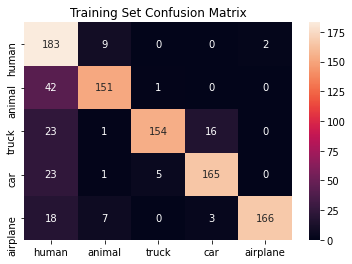

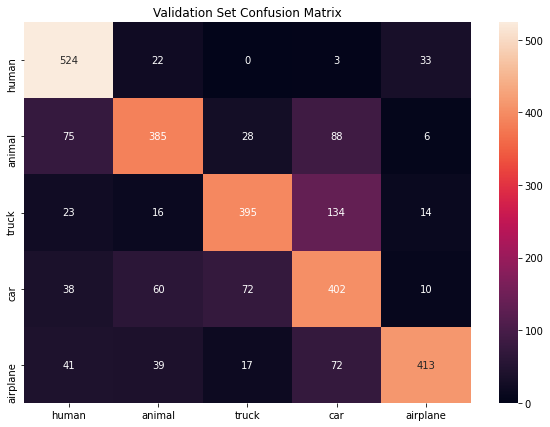

<Figure size 720x504 with 0 Axes>

In [17]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn

data_loaders  = [train_dataloader, val_dataloader]

mode=0

def plot_confusion_matrix(data_loader):
    global mode
    y_true_var, y_pred_var = [], []
       
    for image, label in data_loader:
        image  = image.to(device)
        y_true_var.extend(np.asarray(label.detach().cpu().numpy()))
        model_out = FN(image)
        out = torch.argmax(model_out,axis=1)    
        y_pred_var.extend(np.asarray(out.detach().cpu().numpy()))
        

    confusion_matri = confusion_matrix(y_true_var, y_pred_var, labels=[0,1,2,3,4])

    train_matrix = pd.DataFrame(confusion_matri, index = classes,
                      columns = classes)

    ax = plt.axes()
    plt.figure(figsize = (10,7))
    sn.heatmap(train_matrix, annot=True, ax = ax, fmt="g")
    if(mode==0):
        ax.set_title("Training Set Confusion Matrix")
        mode+=1
    else:
        ax.set_title("Validation Set Confusion Matrix")

for data_load in data_loaders:
    plot_confusion_matrix(data_load)
plt.show()

In [95]:
from tqdm import tqdm
predictions = []
image_path = []
for batch_idx, data in tqdm(enumerate(test_dataloader)):
    img_path, image, _ = data
    image  = image.to(device)
    model_out = FN(image)
    out = torch.argmax(model_out,axis=1)    
    out = np.asarray(out.detach().cpu().numpy())
    predictions.extend(out)
    image_path.extend(img_path)

61it [00:03, 18.70it/s]


In [96]:
predictions = np.expand_dims(np.asarray(predictions),axis=-1)
image_path = np.expand_dims(np.asarray(image_path),axis=-1)

data = np.concatenate((image_path,predictions),axis=1)

submission_df =  pd.DataFrame(data = data, 
                  columns = ['Image_Name','Label'])

submission_df['Image_Name'] = submission_df['Image_Name'].apply(lambda x: x.split('/')[1])
submission_df['Label'] = submission_df['Label'].apply(lambda x: classes[int(x)])
submission_df.to_csv("submission.csv")
submission_df

,Image_Name,Label
0,037164_02_lt.jpg,car
1,034706_02_lt.jpg,human
2,038270_02_lt.jpg,human
3,039051_03_lt.jpg,human
4,035364_02_lt.jpg,car
...,...,...
1935,037851_02_lt.jpg,animal
1936,036290_02_lt.jpg,animal
1937,034252_02_lt.jpg,animal
1938,035574_02_lt.jpg,car
